# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from comp451.classifiers.fc_net import *
from comp451.data_utils import get_CIFAR10_data
from comp451.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from comp451.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
In the file `comp451/layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [5]:
np.random.seed(451)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  9.999077326314113
Mean of train-time output:  9.972885283063809
Mean of test-time output:  9.999077326314113
Fraction of train-time output set to zero:  0.75062
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  9.999077326314113
Mean of train-time output:  10.001915649086255
Mean of test-time output:  9.999077326314113
Fraction of train-time output set to zero:  0.59996
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  9.999077326314113
Mean of train-time output:  9.99517817724202
Mean of test-time output:  9.999077326314113
Fraction of train-time output set to zero:  0.30014
Fraction of test-time output set to zero:  0.0



# Dropout backward pass
In the file `comp451/layers.py`, implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [8]:
np.random.seed(451)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.445608656734099e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:
We are implementing invers dropout, so if we do not divide the values by p, we will not get the accurate results in the test data since scaling will be different. For example, In vanilla dropout, we do not divide the values by p but we multiplicate value with p in test data.

# Fully-connected nets with Dropout
In the file `comp451/classifiers/fc_net.py`, modify your `FullyConnectedNet` implementation to use dropout. Specifically, 
if the constructor of the network receives a value that is not 1 for the `dropout` parameter, then the net should add a 
dropout layer immediately after every Leaky ReLU nonlinearity. After doing so, run the following to numerically gradient-check 
your implementation.

In [10]:
np.random.seed(451)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if you have some errors be on the order of e-4.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3060478762129883
W1 relative error: 3.94e-06
W2 relative error: 1.54e-03
W3 relative error: 2.44e-06
b1 relative error: 6.28e-07
b2 relative error: 9.05e-07
b3 relative error: 8.65e-11

Running check with dropout =  0.75
Initial loss:  2.2917856149298332
W1 relative error: 5.82e-04
W2 relative error: 6.91e-04
W3 relative error: 7.89e-04
b1 relative error: 1.60e-06
b2 relative error: 2.22e-07
b3 relative error: 1.76e-10

Running check with dropout =  0.5
Initial loss:  2.2872396589496775
W1 relative error: 8.45e-06
W2 relative error: 2.86e-04
W3 relative error: 2.48e-06
b1 relative error: 1.85e-07
b2 relative error: 3.92e-08
b3 relative error: 9.02e-11



# Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a keep probability of 0.25. We will then visualize the training and validation accuracies of the two networks over time.

In [11]:
# Train two identical nets, one with dropout and one without
np.random.seed(451)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.40]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver
  print()

1
(Iteration 1 / 125) loss: 9.039360
(Epoch 0 / 25) train acc: 0.200000; val_acc: 0.179000
(Epoch 1 / 25) train acc: 0.328000; val_acc: 0.212000
(Epoch 2 / 25) train acc: 0.458000; val_acc: 0.249000
(Epoch 3 / 25) train acc: 0.530000; val_acc: 0.235000
(Epoch 4 / 25) train acc: 0.608000; val_acc: 0.272000
(Epoch 5 / 25) train acc: 0.714000; val_acc: 0.294000
(Epoch 6 / 25) train acc: 0.742000; val_acc: 0.305000
(Epoch 7 / 25) train acc: 0.796000; val_acc: 0.267000
(Epoch 8 / 25) train acc: 0.804000; val_acc: 0.276000
(Epoch 9 / 25) train acc: 0.804000; val_acc: 0.278000
(Epoch 10 / 25) train acc: 0.872000; val_acc: 0.294000
(Epoch 11 / 25) train acc: 0.922000; val_acc: 0.293000
(Epoch 12 / 25) train acc: 0.942000; val_acc: 0.284000
(Epoch 13 / 25) train acc: 0.962000; val_acc: 0.283000
(Epoch 14 / 25) train acc: 0.978000; val_acc: 0.298000
(Epoch 15 / 25) train acc: 0.974000; val_acc: 0.297000
(Epoch 16 / 25) train acc: 0.962000; val_acc: 0.300000
(Epoch 17 / 25) train acc: 0.972000; v

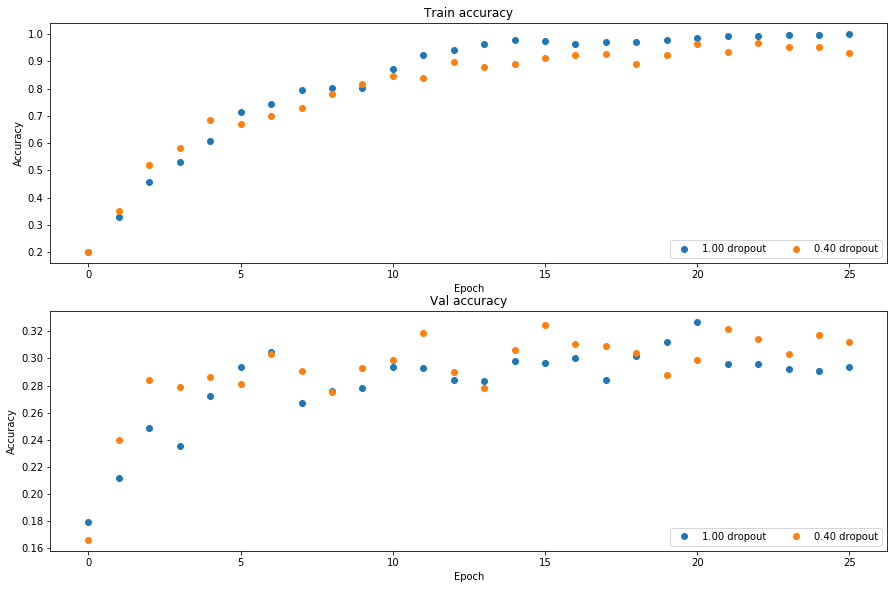

In [12]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
Compare the validation and training accuracies with and without dropout -- what do your results suggest about dropout as a regularizer?

## Answer:
When we observe the training and the test data, we can say that we are overfitting the model. For example, training accuracies without dropout its higher than with dropout since, algorithm learns data too well because of its simplicity. But with dropout which is a regularizer we make the model's job harder which cause it to not to memorize the data, thus test accuracy with dropout became better than without dropout.


